##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#ToDo:
###1.Add downsampling conv2D layers to  gen model
    Generate large output feature map > 64, 64, 3 and the downsample back to 64, 64, 3 for output
###2.Make discriminator more complex.
    a.Add larger filter sizes e.g. 128 or higher
    b.Add upsampling conv2DTranspose layers
###3.Consider dropout for discriminator to prevent overfitting
###4.Consider adding preprocessing operations
###5.Add writing metrics to file : logs.txt


### Import TensorFlow and other libraries

In [ ]:
#Tensorflow import
%tensorflow_version 2.x
import tensorflow as tf

#Model components import
from tensorflow.keras import layers

#NumPy import
import numpy as np

#Image Processing imports
from PIL import Image, ImageOps
from pylab import *
from IPython import display
import matplotlib.pyplot as plt
import imageio

#Utilities imports
import os
import time
import glob

In [ ]:
#Unzip Data Set
if not os.path.exists(os.path.join(os.getcwd(),'data_set')):
  try:
    !unzip data_set.zip
  except:
    print('Error data set not found...did you forget to upload it?')
#Get Dataset Path
data_set_path = os.path.join(os.getcwd(),'data_set/images')

In [ ]:
#Possible pre-processing ideads:
# 1.Grayscale
# 2.Invert
# 3.Blurr

#Params
BUFFER_SIZE = 60000
BATCH_SIZE = 1
img_dimensions = (64, 64)
data_set_as_strings = os.listdir(data_set_path) #list of image strings
data_set_len = len(data_set_as_strings) - 1 #ignoring .DS_Store
data_set = np.zeros(dtype=np.uint64,shape=(data_set_len,64,64,3))

#Convert to np.array
for index, img in enumerate(data_set_as_strings):
  if not (img == '.DS_Store'):#ignore .DS_Store
    img = Image.open(data_set_path + '/' + img)
    if img.mode == 'RGBA': #conver to RGB
      img = img.convert('RGB')
    img = img.resize(img_dimensions, Image.ANTIALIAS)
    img_array = np.array(img)
    data_set[index - 1] = img_array
data_set = (data_set - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(data_set).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*3, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 3)))
    assert model.output_shape == (None, 4, 4, 3) # Note: None is the batch size
    model.add(layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', data_format='channels_last' ,
                                     use_bias=False))
    print(model.output_shape)
    assert model.output_shape == (None, 8, 8, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    
    assert model.output_shape == (None, 16, 16, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())



    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())




    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    print(model.output_shape)
    assert model.output_shape == (None, 64, 64, 3)

    return model

Use the (as yet untrained) generator to create an image.

(None, 8, 8, 16)
(None, 64, 64, 3)


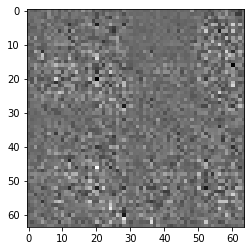

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00259725]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [ ]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return {'g_loss':gen_loss, 'd_loss':disc_loss, 'GOG':gradients_of_generator, 'GOD': gradients_of_discriminator }

In [ ]:
def train(dataset, epochs):
  logs = open('logs.txt', 'a')
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      metrics = train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print (f"g_loss : {metrics['g_loss']} - d_los : {metrics['d_loss']}")
    # print (f"gen_gradients:{metrics['GOG']} - disc_gradients: {metrics['GOD']}")
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

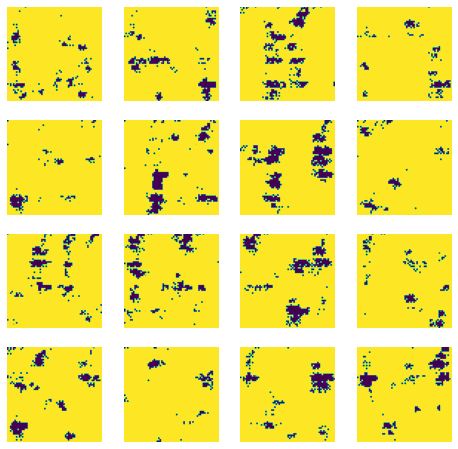

Time for epoch 7 is 17.37844443321228 sec
g_loss : 3.182530403137207 - d_los : 0.052710067480802536


KeyboardInterrupt: ignored

In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.